# Inference

Have a look into the predictions of a certain model on a specific orbit!

In [1]:
import utils.constants as c
import utils.harry_plotter as harry_plotter
import utils.io as io
import ordinary_training
import torch
import torch.nn.functional as F

from tqdm.notebook import tqdm
from learning.datasets import MessengerDataset
from torchinfo import summary

In [2]:
MODEL_RUN = 783
ORBIT_ID = 42

Load model checkpoint and hyperparameters

In [3]:
model, hparams = ordinary_training.load_model(MODEL_RUN)

Load the specified inference orbit

In [4]:
ds = MessengerDataset(io.resolve_path(c.DATA_DIR),
                      split="eval",
                      features=hparams["features"],
                      window_size=hparams["window_size"],
                      future_size=hparams["future_size"],
                      use_orbits=[ORBIT_ID])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.11it/s]


Summarize the model

In [5]:
print(model)
summary(model, input_size=(hparams["batch_size"], len(hparams["features"]), hparams["window_size"]), device="cpu")

CRNN(
  (conv_stack): ConvStack(
    (conv0): Conv1d(9, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (relu0): ReLU()
    (conv1): Conv1d(128, 128, kernel_size=(5,), stride=(1,), padding=(2,))
    (relu1): ReLU()
    (conv2): Conv1d(128, 128, kernel_size=(7,), stride=(1,), padding=(3,))
    (relu2): ReLU()
  )
  (zero_pad): ConstantPad1d(padding=(0, 20), value=0)
  (swap_in): Transposer(dim1=-1, dim2=-2)
  (lstm_stack): RecurrentStack(
    (lstm0): LSTM(128, 32, batch_first=True, bidirectional=True)
    (proj0): Projector(dim=0)
    (lstm1): LSTM(64, 32, batch_first=True, bidirectional=True)
    (proj1): Projector(dim=0)
    (linear): Linear(in_features=64, out_features=5, bias=True)
  )
  (swap_out): Transposer(dim1=-1, dim2=-2)
)


Layer (type:depth-idx)                   Output Shape              Param #
CRNN                                     --                        --
├─ConvStack: 1-1                         [1024, 128, 120]          --
│    └─Conv1d: 2-1                       [1024, 128, 120]          3,584
│    └─ReLU: 2-2                         [1024, 128, 120]          --
│    └─Conv1d: 2-3                       [1024, 128, 120]          82,048
│    └─ReLU: 2-4                         [1024, 128, 120]          --
│    └─Conv1d: 2-5                       [1024, 128, 120]          114,816
│    └─ReLU: 2-6                         [1024, 128, 120]          --
├─ConstantPad1d: 1-2                     [1024, 128, 140]          --
├─Transpose: 1-3                         [1024, 140, 128]          --
├─RecurrentStack: 1-4                    [1024, 140, 5]            --
│    └─LSTM: 2-7                         [1024, 140, 64]           41,472
│    └─Projector: 2-8                    [1024, 140, 64]           --

Put all window slices into one large batch

In [6]:
all_windows = torch.stack([sample for sample, label in tqdm(ds)])

  0%|          | 0/43323 [00:00<?, ?it/s]

Classify each time step in each of the windows

In [7]:
model.eval()
pred = model(all_windows)                   # predict class probabilities
pred = pred[:, :, :hparams["window_size"]]  # discard future predictions
pred = F.softmax(pred, dim=1)               # convert logits to probabilities
pred = pred.flip([2])                       # reverse the time dimension

In [8]:
labels = torch.tensor([pred.diagonal(dim1=0, dim2=2, offset=i).mean(dim=1).argmax()
                       for i in tqdm(range(pred.shape[2] - 1, -pred.shape[0], -1))])

  0%|          | 0/43442 [00:00<?, ?it/s]

Reduce predictions for each time step to a single one by majority voting

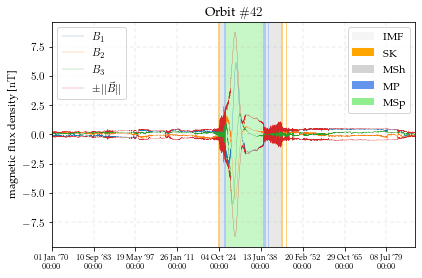

In [9]:
df_orbit = ds.get_orbits()[0]
figpath = str(io.resolve_path(c.TEMP_DIR) / c.MESSENGER(ORBIT_ID)) + "_inference.pdf"
harry_plotter.plot_orbit(
    df_orbit.index,
    (df_orbit["BX_MSO"],
    df_orbit["BY_MSO"],
    df_orbit["BZ_MSO"]),
    symbol="B",
    labels=labels,
    title=f"Orbit $\#{ORBIT_ID}$",
    ylabel="magnetic flux density [\si{nT}]",
    outfile=figpath
)